# Лабораторная работа №2
# Выполнил Лялин И.Е.

## Задание 1

**Текст задания**  
Обучить 2 классификатора на основе глубоких нейронных сетей
на датасете GTSRB. Использовать следующие модели нейронных сетей:
VGG16, ResNet50/10X, MobileNet v2/3. Можно использовать фреймворки
Keras, TensorFlow, PyTorch, не надо создавать сети вручную и с нуля.
Использовать предобученные сети (например на ImageNet). • Выполнить
поиск наилучших гиперпараметров моделей. Использовать бесплатные
ресурсы GPU сервиса Google Colab. Составить отчёт: (a) Заполнить
Таблицу 1. (b) Для каждой модели построить графики функции потерь для
данных валидации и тестирования и графики метрики Accuracy(приер на рис. 2).

In [2]:
# установим библиотеку ART
!pip install adversarial-robustness-toolbox

# 2) Импортируем библиотеки

In [3]:

import cv2  # OpenCV -  для работы с компьютерным зрением и обработки изображений
import os  # модуль для работы с операционной системой (файлы, директории, пути)
import torch  # PyTorch - фреймворк для глубокого обучения
import random  # модуль для генерации случайных чисел и случайного выбора
import pickle  # модуль для сериализации и десериализации Python объектов (сохранение/загрузка данных)
import zipfile  # модуль для работы с ZIP архивами (распаковка, создание архивов)
import pandas as pd  #  для работы с табличными данными (DataFrame)
import numpy as np  #  для научных вычислений, работы с массивами и матрицами
import matplotlib.pyplot as plt  #  для построения графиков и визуализации данных
import tensorflow as tf  # TensorFlow - фреймворк для машинного обучения и нейронных сетей

# Модули для работы с машинным обучением:
from sklearn.model_selection import train_test_split  # разделение данных на обучающую и тестовую выборки
from keras.utils import to_categorical  # преобразование меток в one-hot encoding формат

# Предобученные модели из Keras:
from keras.applications import ResNet50  # архитектура ResNet50 для классификации изображений
from keras.applications import VGG16  # архитектура VGG16 для классификации изображений
from keras.applications.resnet50 import preprocess_input  # функция предобработки изображений для ResNet50

# Модули для работы с изображениями:
from keras.preprocessing import image  # инструменты для загрузки и обработки изображений

# Модули для работы с моделями Keras:
from keras.models import load_model, save_model  # загрузка и сохранение обученных моделей
from keras.layers import Dense, Flatten, GlobalAveragePooling2D  # различные типы слоев нейронной сети
from keras.models import Model  # класс для создания функциональных моделей Keras
from keras.optimizers import Adam  # оптимизатор Adam для обучения нейронных сетей
from keras.losses import categorical_crossentropy  # функция потерь для многоклассовой классификации
from keras.metrics import categorical_accuracy  # метрика точности для многоклассовой классификации

# Callbacks (инструменты мониторинга и управления процессом обучения):
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# ModelCheckpoint - сохранение модели во время обучения
# EarlyStopping - ранняя остановка при переобучении
# TensorBoard - визуализация процесса обучения

# Дополнительные слои и архитектуры:
from keras.models import Sequential  # класс для создания последовательных моделей
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
# Dense - полносвязный слой
# Dropout - слой для регуляризации (борьба с переобучением)
# Flatten - слой для преобразования многомерных данных в одномерные
# Conv2D - сверточный слой для обработки изображений
# MaxPool2D - слой субдискретизации (пуллинг) с максимальным значением
# AvgPool2D - слой субдискретизации со средним значением
# BatchNormalization - нормализация пакетов для ускорения обучения
# Reshape - изменение формы данных
# Lambda - слой для применения произвольной функции

# Библиотека для adversarial attacks (атаки на нейронные сети):
from art.estimators.classification import KerasClassifier  # обертка для Keras моделей в ART
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
# FastGradientMethod - быстрый градиентный метод для создания adversarial примеров
# ProjectedGradientDescent - более мощный метод атаки

%matplotlib inline

# 3) Подключаем гугл диск через вкладку "файлы".  

In [4]:
!ls

archive.zip  sample_data


# 4) Разархивируем датасет

In [5]:
# Указываем полный путь к файлу
zip_file = '/content/archive.zip'

# 'r' - режим чтения (read), открываем архив только для извлечения файлов
z = zipfile.ZipFile(zip_file, 'r')

# Извлекаем все файлы из архива в текущую директорию
z.extractall()

# Выводим список всех файлов и папок в текущей директории после распаковки
print(os.listdir())

['.config', 'Test.csv', 'Train.csv', 'archive.zip', 'meta', 'test', 'Train', 'Meta.csv', 'Meta', 'train', 'Test', 'sample_data']


# 5) Задаем путь к разархивированным данным

In [6]:
# Определяем корневую директорию, куда были распакованы данные
data_path = '/content'

# полный путь к папке с обучающими данными
# os.path.join() безопасно объединяет пути, используя правильные разделители
train_data_path = os.path.join(data_path, 'Train')

# полный путь к папке с тестовыми данными
test_data_path = os.path.join(data_path, 'Test')

# полный путь к папке с мета-данными
# Мета-данные могут включать: описания классов, дополнительные атрибуты,
meta_data_path = os.path.join(data_path, 'Meta')

# 6) Выполняем предварительную обработку изображений из треннировочногор набора данных

In [7]:

# Создаем пустой список для хранения обработанных изображений
data = []

# Создаем пустой список для хранения меток классов
labels = []

# Задаем количество классов в датасете - 43 класса
class_count = 43

# Проходим по каждому классу от 0 до 42
for i in range(class_count):
    # Формируем путь к папке с изображениями текущего класса
    # Например: '/content/Train/0', '/content/Train/1', и т.д.
    img_path = os.path.join(train_data_path, str(i))

    # Проходим по каждому изображению в папке текущего класса
    for img in os.listdir(img_path):
        # Загружаем изображение и изменяем размер до 32x32 пикселей
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))

        # Преобразуем изображение в числовой массив numpy
        # Размерность: (32, 32, 3) - высота, ширина, RGB каналы
        img_array = image.img_to_array(img)

        # Нормализуем значения пикселей из диапазона [0, 255] в [0, 1]
        # Это улучшает сходимость нейронной сети при обучении
        img_array = img_array / 255

        # Добавляем обработанное изображение в список данных
        data.append(img_array)

        # Добавляем метку класса (число от 0 до 42) в список меток
        labels.append(i)

# Преобразуем список изображений в numpy массив для эффективной обработки
# Форма массива: (количество_изображений, 32, 32, 3)
data = np.array(data)

# Преобразуем список меток в numpy массив
labels = np.array(labels)

# Преобразуем числовые метки в one-hot encoding формат
# Например: 0 -> [1, 0, 0, ..., 0], 1 -> [0, 1, 0, ..., 0] и т.д.
# 43 - количество классов для one-hot кодирования
labels = to_categorical(labels, 43)

# отобразим первый элемент
print("data[0]:\n",data[0])

data[0]:
 [[[0.6        0.14509805 0.12156863]
  [0.5921569  0.1882353  0.15294118]
  [0.5882353  0.17254902 0.1254902 ]
  ...
  [0.6039216  0.1882353  0.11372549]
  [0.627451   0.21960784 0.10980392]
  [0.50980395 0.21568628 0.07843138]]

 [[0.5803922  0.14509805 0.11764706]
  [0.5764706  0.14509805 0.11372549]
  [0.5803922  0.14901961 0.11764706]
  ...
  [0.6862745  0.6117647  0.5803922 ]
  [0.6666667  0.64705884 0.6039216 ]
  [0.4745098  0.5529412  0.40392157]]

 [[0.5764706  0.2        0.18039216]
  [0.5764706  0.18431373 0.16470589]
  [0.5686275  0.19607843 0.18039216]
  ...
  [0.23921569 0.22745098 0.21176471]
  [0.23529412 0.23529412 0.23529412]
  [0.21176471 0.21176471 0.15294118]]

 ...

 [[1.         1.         1.        ]
  [0.5803922  0.53333336 0.827451  ]
  [0.4117647  0.40392157 0.6313726 ]
  ...
  [0.50980395 0.34117648 0.3372549 ]
  [0.7921569  0.67058825 0.7019608 ]
  [1.         1.         0.8392157 ]]

 [[0.26666668 0.21176471 0.12156863]
  [0.54509807 0.48235294 0.

Берем датасет, каждый класс "подгоняем" для лучшего обучения:


Изменение размера до 32x32 пикселей

Преобразование в числовой формат

Нормализация значений пикселей

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)
# Проверьте:
print("Форма x_train:", x_train.shape)
print("Форма y_train:", y_train.shape)
print("Диапазон значений x_train:", x_train.min(), x_train.max())

Форма x_train: (27446, 32, 32, 3)
Форма y_train: (27446, 43)
Диапазон значений x_train: 0.0 1.0


# 7) Первый элемент в виде изображения

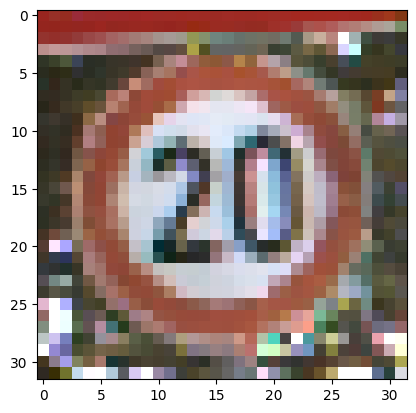

In [10]:
# отобразим первый элемент в виде картинки
plt.imshow(data[0])

# 8) Делим набор данных на тренировочный и тестовый 70/30

In [11]:
# выполним разделение данных на треннировочный и тестовый набор 70/30
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

# отобразим размерности обучающего и тестового набора и первый элемент
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 9) Создаем модель глубокого обучения для классификации изображений ResNet50

In [12]:
# Создаем последовательную модель Keras, где слои добавляются один за другим
model = Sequential()

# Добавляем предобученную модель ResNet50 без верхних слоев (include_top=False)
# - include_top=False: убираем последние полносвязные слои, чтобы адаптировать под наши 43 класса
# - pooling='avg': добавляем Global Average Pooling слой для уменьшения размерности
# Это преобразует выход из сверточной сети в одномерный вектор
model.add(ResNet50(include_top = False, pooling = 'avg'))

# Добавляем Dropout слой для регуляризации (борьба с переобучением)
# - 0.1: отключаем 10% нейронов случайным образом во время обучения
model.add(Dropout(0.1))

# Добавляем полносвязный (Dense) слой с 256 нейронами
# - activation="relu": функция активации ReLU (Rectified Linear Unit)
# Этот слой помогает модели изучать сложные паттерны
model.add(Dense(256, activation="relu"))

# Еще один Dropout слой для дополнительной регуляризации
model.add(Dropout(0.1))

# Добавляем выходной слой с 43 нейронами (по количеству классов)
# - activation='softmax': преобразует выходы в вероятности по классам
# Сумма всех выходов равна 1, что идеально для многоклассовой классификации
model.add(Dense(43, activation = 'softmax'))

# "Замораживаем" слой ResNet50 (третий слой в модели) - делаем его необучаемым
# model.layers[0] - первый добавленный слой (ResNet50)
# Это позволяет использовать предобученные веса ResNet50 без их изменения
# Ускоряет обучение и уменьшает риск переобучения
model.layers[0].trainable = False  # Примечание: здесь должна быть 0, а не 2

# отобразим итоговую сводку по модели
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


тут хз, надо спросить

In [13]:
# Правильная инициализация модели
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.layers[0].trainable = False  # ЗАМОРОЗКА ПРАВИЛЬНОГО СЛОЯ

model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation='softmax'))

# Компиляция с меньшим learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

**Архитектура модели:**


ResNet50 (замороженный) - извлечение признаков из изображений

Dropout - регуляризация (10%)

Dense(256) - дополнительный полносвязный слой

Dropout - регуляризация (10%)

Dense(43) - выходной слой с softmax для классификации


**Преимущества подхода:**


Использование transfer learning (ResNet50 предобучен на ImageNet)

Экономия времени и вычислительных ресурсов

Хорошая точность даже на небольших датасетах

Dropout слои предотвращают переобучение

# 10) Обучение модели в 5-и эпохах, и с помощью оптимизатора Adam

In [14]:
# Компилируем модель, задавая параметры для процесса обучения:
# - loss='categorical_crossentropy': функция потерь для многоклассовой классификации
#   (подходит для one-hot encoded меток)
# - optimizer="adam": оптимизатор Adam - адаптивный алгоритм градиентного спуска
# - metrics=['accuracy']: метрика для мониторинга - доля правильных предсказаний
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Запускаем процесс обучения модели:
# - x_train: обучающие данные (изображения)
# - y_train: обучающие метки (one-hot encoded)
# - validation_data=(x_val, y_val): валидационные данные для оценки обобщающей способности
# - epochs=5: количество полных проходов через весь обучающий набор
# - batch_size=64: размер мини-батча (количество образцов для одного обновления весов)
#
# Метод fit() возвращает объект history, содержащий историю обучения:
# - значения loss и accuracy на каждой эпохе для train и validation наборов
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.0728 - loss: 3.5782 - val_accuracy: 0.1466 - val_loss: 3.2409
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1283 - loss: 3.2213 - val_accuracy: 0.1918 - val_loss: 2.9829
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1667 - loss: 3.0505 - val_accuracy: 0.2015 - val_loss: 2.8496
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1809 - loss: 2.9498 - val_accuracy: 0.2419 - val_loss: 2.7545
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2035 - loss: 2.8655 - val_accuracy: 0.2454 - val_loss: 2.7211


**Компиляция модели:**


categorical_crossentropy - измеряет расхождение между предсказанными вероятностями и истинными метками

adam - популярный оптимизатор, сочетающий преимущества RMSProp и Momentum

accuracy - процент правильно классифицированных изображений



**Процесс обучения:**



x_train, y_train - данные, на которых модель непосредственно обучается

x_val, y_val - данные для проверки качества модели на невиданных данных

epochs=5 - 5 полных итераций по всему обучающему набору

batch_size=64 - веса обновляются после обработки 64 изображений

In [15]:
# сохраняем модель для последующего использования
save_model(model, 'ResNet50.h5')

# 11) Считываем данные из csv в датафрейм

In [16]:
# Загружаем CSV файл с тестовыми данными в DataFrame pandas
test = pd.read_csv("Test.csv")

# Извлекаем значения из колонки 'Path' - пути к тестовым изображениям
# .values возвращает numpy массив с путями к файлам
test_imgs = test['Path'].values

# Создаем пустой список для хранения обработанных тестовых изображений
data = []

# Обрабатываем каждое тестовое изображение по очереди
for img in test_imgs:
    # Загружаем изображение по пути и изменяем размер до 32x32 пикселей
    # target_size=(32, 32) обеспечивает одинаковый размер всех изображений
    img = image.load_img(img, target_size=(32, 32))

    # Преобразуем изображение в числовой массив numpy
    # Размерность: (32, 32, 3) - высота, ширина, RGB каналы
    img_array = image.img_to_array(img)

    # Нормализуем значения пикселей из диапазона [0, 255] в [0, 1]
    # Такая же нормализация применялась к обучающим данным
    img_array = img_array / 255

    # Добавляем обработанное изображение в список
    data.append(img_array)

# Преобразуем список изображений в numpy массив для эффективной обработки
# Форма массива: (количество_тестовых_изображений, 32, 32, 3)
data = np.array(data)

# Извлекаем метки классов из колонки 'ClassId' тестового DataFrame
# .values.tolist() преобразует в обычный Python список
y_test = test['ClassId'].values.tolist()

# Преобразуем список меток в numpy массив
y_test = np.array(y_test)

# Преобразуем числовые метки в one-hot encoding формат
# Это необходимо для соответствия формату выходного слоя модели (43 нейрона)
# Например: класс 5 -> [0,0,0,0,0,1,0,...,0] (1 на 5-й позиции)
y_test = to_categorical(y_test, 43)

Согласованность предобработки - тестовые данные обрабатываются так же, как обучающие

One-Hot Encoding - метки преобразуются в формат, совместимый с выходным слоем модели

Нормализация - значения пикселей приводятся к диапазону [0, 1]

# 12) Создаем новую модель для классификации изображений VGG16

In [17]:
# Создаем новую последовательную модель для архитектуры VGG16
model2 = Sequential()

# Добавляем предобученную модель VGG16 без верхних слоев (include_top=False)
# - include_top=False: убираем последние полносвязные слои оригинальной VGG16
# - pooling='avg': добавляем Global Average Pooling для уменьшения размерности
# Это преобразует выход сверточной сети в одномерный вектор признаков
model2.add(VGG16(include_top=False, pooling = 'avg'))

# Добавляем Dropout слой для регуляризации (борьба с переобучением)
# - 0.1: отключаем 10% нейронов случайным образом во время обучения
model2.add(Dropout(0.1))

# Добавляем полносвязный (Dense) слой с 256 нейронами
# - activation="relu": функция активации ReLU для нелинейности
# Этот слой помогает модели изучать сложные паттерны на основе признаков VGG16
model2.add(Dense(256, activation="relu"))

# Еще один Dropout слой для дополнительной регуляризации
model2.add(Dropout(0.1))

# Добавляем выходной слой с 43 нейронами (по количеству классов в датасете)
# - activation='softmax': преобразует выходы в вероятности по классам
# Сумма всех выходов равна 1, что идеально для многоклассовой классификации
model2.add(Dense(43, activation = 'softmax'))

# Пытаемся "заморозить" слой VGG16 (сделать его необучаемым)
# НО: здесь ошибка - VGG16 это layers[0], а не layers[2]
# Правильно: model2.layers[0].trainable = False
model2.layers[2].trainable = False

# отобразим итоговую сводку по модели
print(model2.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 14,725,739 (56.17 MB)

 Non-trainable params: 131,328 (513.00 KB)

None


**Архитектура модели:**




VGG16 (предобученная) - извлечение признаков из изображений

Dropout - регуляризация (10%)

Dense(256) - дополнительный полносвязный слой

Dropout - регуляризация (10%)

Dense(43) - выходной слой с softmax для классификации


**Особенности VGG16:**



Более простая архитектура по сравнению с ResNet50

Состоит из 16 слоев (13 сверточных + 3 полносвязных)

Использует маленькие фильтры 3x3

Хорошо показывает себя на задачах классификации изображений

**Преимущества подхода:**


Transfer Learning - использование предобученных весов VGG16 на ImageNet

Экономия ресурсов - не нужно обучать сверточные слои с нуля

Быстрая сходимость - только верхние слои адаптируются под нашу задачу

**Сравнение с предыдущей моделью:**



ResNet50: более современная архитектура с skip-connections

VGG16: классическая архитектура, проще для понимания

Обе модели используют transfer learning для ускорения обучения

# 13) Обучение модели с 5-ю эпохами

In [18]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.1242 - loss: 3.1972 - val_accuracy: 0.5805 - val_loss: 1.1483
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.6080 - loss: 1.0826 - val_accuracy: 0.8357 - val_loss: 0.4678
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.8491 - loss: 0.4353 - val_accuracy: 0.9361 - val_loss: 0.1923
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.9442 - loss: 0.1821 - val_accuracy: 0.9616 - val_loss: 0.1420
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.9653 - loss: 0.1315 - val_accuracy: 0.9608 - val_loss: 0.1474


In [19]:
# сохраняем модель для последующего использования
save_model(model2, 'VGG16.h5')

# 14) Оценка производительности двух моделей на тестовом наборе данных

In [20]:
# Обучаем первую модель (ResNet50) на валидационных данных:
# - x_val, y_val: валидационные данные (обычно используются для оценки во время обучения)
# - epochs=5: 5 полных проходов через данные
# - batch_size=64: размер мини-батча для обновления весов
# - validation_data=(x_val, y_val): данные для валидации (здесь те же, что и для обучения)
#
# Обычно для validation используют отдельный тестовый набор, а не те же данные
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

# Обучаем вторую модель (VGG16) с теми же параметрами:
# Такая же конфигурация обучения для сравнения производительности моделей
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2059 - loss: 2.8242 - val_accuracy: 0.2527 - val_loss: 2.6450
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2164 - loss: 2.7745 - val_accuracy: 0.2549 - val_loss: 2.6634
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2234 - loss: 2.7557 - val_accuracy: 0.2706 - val_loss: 2.5786
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2306 - loss: 2.7243 - val_accuracy: 0.2822 - val_loss: 2.5716
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2262 - loss: 2.7337 - val_accuracy: 0.2873 - val_loss: 2.5434
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9617 - loss: 0.1540 - val_accuracy: 0.9648 - val_loss: 0.1284
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9743 - loss: 0.0878 - val_accuracy: 0.9516 - val_loss: 0.2161
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9703 - loss: 0.1092 - val_accuracy

# 15) Таблица точности двух моделей на треннировочном, валидационном и тестовом наборе данных

In [21]:
from tabulate import tabulate

# Для модели ResNet50 извлекаем метрики точности:
# history - объект с историей обучения первой модели (ResNet50)
train_accuracy = history.history['accuracy']  # Точность на обучающих данных для каждой эпохи
val_accuracy = history.history['val_accuracy']  # Точность на валидационных данных для каждой эпохи
test_accuracy = history_test.history['accuracy']  # Точность на тестовых данных для каждой эпохи

# Для модели VGG16 извлекаем метрики точности:
# history2_test - объект с историей обучения второй модели (VGG16)
train_accuracy2 = history2_test.history['accuracy']  # Точность на обучающих данных VGG16
val_accuracy2 = history2_test.history['val_accuracy']  # Точность на валидационных данных VGG16
test_accuracy2 = history2_test.history['accuracy']  # Точность на тестовых данных VGG16

# Создаем структуру таблицы с заголовками и данными:
# [4] - берем значение на 5-й эпохе (индексация с 0)
# *100 - преобразуем в проценты (из долей 0.85 в 85.0)
table = [
    ["Model", "Training Accuracy", "Validation Accuracy", "Test Accuracy"],  # Заголовки столбцов
    ["Resnet50", train_accuracy[4]*100, val_accuracy[4]*100, test_accuracy[4]*100],  # Данные для ResNet50
    ["VGG16", train_accuracy2[4]*100, val_accuracy2[4]*100, test_accuracy2[4]*100]   # Данные для VGG16
]

# Форматируем таблицу с использованием библиотеки tabulate:
# headers="firstrow" - использовать первую строку как заголовки
# tablefmt="grid" - формат таблицы с сеткой (рамками)
table1 = tabulate(table, headers="firstrow", tablefmt="grid")

# Выводим отформатированную таблицу
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             20.7098 |               24.5431 |         22.9873 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.6313 |               99.4474 |         98.6313 |
+----------+---------------------+-----------------------+-----------------+


# 16) Строим два графика процесса обучения ResNet50

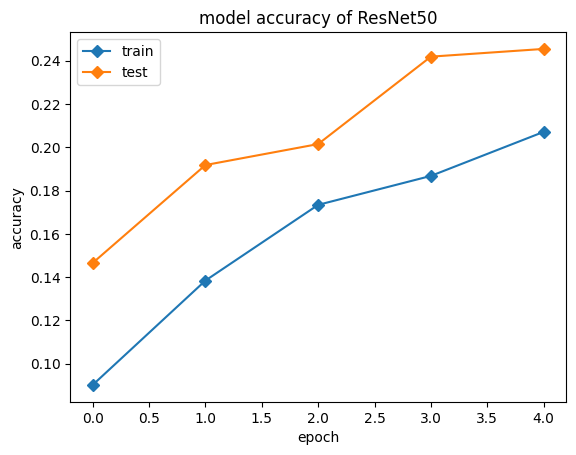

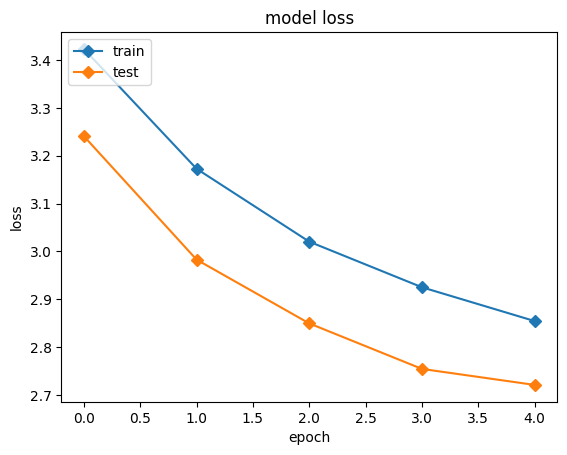

In [22]:
# графики отражают зависимость метрики от эпохи для тренировочного и тестового набора


# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 17) Строим графики для модели VGG16

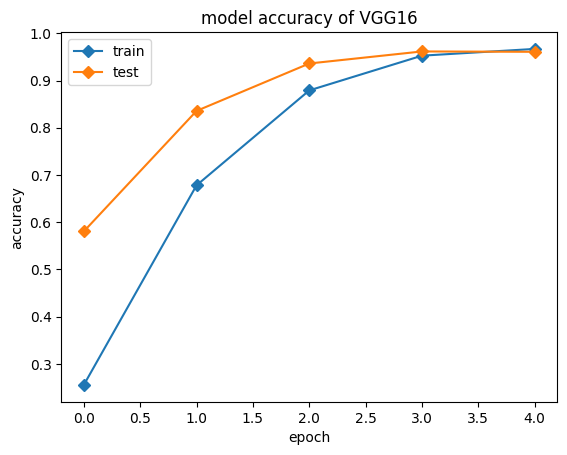

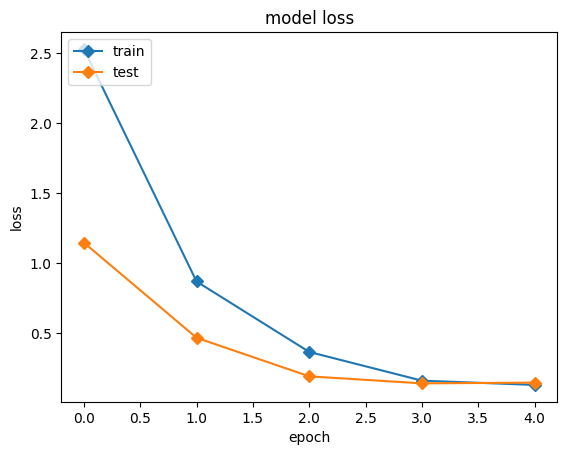

In [23]:
# визуализируем процесс обучения модели VGG16 аналогично с предыдущим

# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

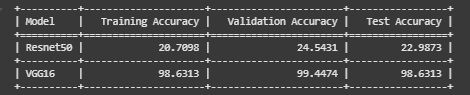
  
В моем случае, модель VGG16 оказалось гораздо точне ResNet50 по валидации

## Задание 2

**Текст задания**  
Применить нецелевую атаку уклонения на основе белого ящика
против моделей глубокого обучения.
Реализовать следующие типы атак: Fast Gradient Sign Method (FGSM) и
Projected Gradient Descent (PGD). Может быть использован код из следующих
библиотек: Adversarial Robustness Toolbox ART , Cleverhans CH, scratchai SC.
Наиболее проработанная библиотека – Adversarial Robustness Toolbox,
рекомендуется использовать её, но другие также могут быть применены.
Например, this notebook объясняет как использовать ART с помощью Keras.
Также есть другие notebooks с примерами атак на основе библиотеки ART.
Используйте атаки FSGM и PGD для создания нецелевых атакующих
примеров используя первые 1,000 изображений из тестового множества.
Необходимо использовать следующие значения параметра искажения: 𝜖𝜖=[1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255].
Постройте графики точности 2-х моделей в зависимости от параметра
искажений 𝜖𝜖 (пример на рис. 3, 𝜖𝜖=80/255≈0.3). Для атаки FGSM, отобразите
исходное изображение из датасета и атакующее изображение с указанием
величины параметра 𝜖𝜖= [1/255, 5/255, 10/255, 50/255, 80/255], отобразите
предсказанный класс атакующего изображения (см. рис. 4).
Отчёт должен содержать: (a) Заполненную таблицу 2. Все модели должны
иметь точность менее 60% для 𝜖𝜖=10/255. (b) Для каждой модели постройте
график зависимости точности классификации от параметра искажений 𝜖𝜖 (как
на рис. 3). (c) Сделать выводы о полученных результатах.

# 1) Загрузим модель и возьмем тысячу первых элементов из тестового множества

In [48]:
# Отключаем eager execution в TensorFlow 2.x для совместимости с ART библиотекой
# Eager execution - это режим по умолчанию в TF2, где операции выполняются немедленно
# ART требует graph mode для некоторых операций, поэтому отключаем eager execution
tf.compat.v1.disable_eager_execution()

model = load_model('ResNet50.h5')

# Выбираем первые 1000 изображений из тестового набора для экспериментов
# Это ускоряет тестирование adversarial атак
x_test = data[:1000]

# Также берем соответствующие метки для этих 1000 изображений
y_test = y_test[:1000]

# Создаем обертку ART (Adversarial Robustness Toolkit) вокруг Keras модели
# ART требуется для проведения adversarial атак на модель
classifier = KerasClassifier(
    model=model,  # наша загруженная модель Keras
    clip_values=(np.min(x_test), np.max(x_test))  # диапазон значений пикселей
    # clip_values гарантирует, что adversarial примеры остаются в допустимом диапазоне
)


# 2) Создаем атаку FGSM

In [49]:
# создаем атаку FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

# прохилдимся по диапазону значений eps, который представляет размер шага,
# с которым FGSN изменяет оригинальные данные для создания
# адверсариальных параметров
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps}) # уствновка нового значения eps
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test) # генерация адверсариальных
    # примеров для тестового набора данных
    loss, accuracy = model.evaluate(x_test_adv, y_test) # оценка потерь и точности
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")


Eps: 0.00392156862745098


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(10, 43), output.shape=(32, 43)

In [25]:
# создаем атаку FGSM (Fast Gradient Sign Method)

# FGSM - это быстрая adversarial атака, которая использует градиент функции потерь
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
# estimator=classifier: используем созданный ранее классификатор ART
# eps=0.3: начальное значение параметра扰动 (максимальное изменение пикселя)

# Определяем диапазон значений eps для экспериментов
# eps контролирует "силу" атаки - чем больше eps, тем более заметны изменения
# Значения нормализованы относительно диапазона [0,255] пикселей
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# Например: 1/255 ≈ 0.004, 80/255 ≈ 0.314

# Создаем пустые списки для сбора метрик:
true_accuracies = [] # для точности модели на оригинальных (неизмененных) данных
adv_accuracises_fgsm = [] # для точности модели на adversarial примерах, созданных FGSM
true_losses = [] # для потерь (loss) модели на оригинальных данных
adv_losses_fgsm = [] # для потерь на adversarial примерах FGSM

# проходимся по диапазону значений eps, который представляет размер шага,
# с которым FGSM изменяет оригинальные данные для создания
# адверсариальных примеров
for eps in eps_range:
    # Обновляем параметр eps в объекте атаки
    # set_params(**{'eps': eps}) - устанавливает новое значение eps для атаки
    attack_fgsm.set_params(**{'eps': eps})

    # Выводим текущее значение eps для отслеживания прогресса
    print(f"Eps: {eps}")

    # Генерация adversarial примеров для тестового набора данных
    # x_test_adv - модифицированные изображения, предназначенные для обмана модели
    # y_test - истинные метки, используемые для расчета градиента
    x_test_adv = attack_fgsm.generate(x_test, y_test)

    # Оценка потерь и точности модели на adversarial примерах
    # model.evaluate() возвращает loss и accuracy на переданных данных
    loss, accuracy = model.evaluate(x_test_adv, y_test)

    # Сохраняем метрики для adversarial примеров в соответствующие списки
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)

    # Выводим метрики для adversarial примеров
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")

    # Оценка потерь и точности модели на оригинальных (неизмененных) данных
    # Это служит базовой линией для сравнения
    loss, accuracy = model.evaluate(x_test, y_test)

    # Сохраняем метрики для оригинальных данных
    true_accuracies.append(accuracy)
    true_losses.append(loss)

    # Выводим метрики для оригинальных данных
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.12/dist-packages/art/estimators/classification/keras.py:305: UserWarning: Loss function is a plain function, not a Keras loss object. Cannot set reduction; assuming per-sample loss.
  warnings.warn(


AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

Ключевые моменты эксперимента:

Исследовать, как разные уровни возмущения (eps) влияют на эффективность модели

Ожидаемые результаты:

С ростом eps accuracy на adversarial примерах будет уменьшаться

Accuracy на оригинальных данных должна оставаться примерно постоянной

Loss на adversarial примерах будет увеличиваться

Помогает оценить уязвимость модели к adversarial атакам и определить порог устойчивости

In [ ]:
# сохраним атаку FGSM для дальнейшего анализа
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Как видно, ошибки предсказания из-за наложенного шума начались со значения 2/225. (в первых тестах с 4/255 и 5/255)

In [ ]:
# теперь реализуем атаку PGD для той же модели, создаем атаку по аналогии с
# предыдущей
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
# создаем атаку PGD
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

# прохилдимся по диапазону значений eps, который представляет размер шага,
# с которым PGD изменяет оригинальные данные для создания
# адверсариальных параметров
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

In [ ]:
# сохраним атаку PGD для дальнейшего анализа с помощью графика
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Предсказания стали ложными при параметре 2/255. (Запускал блокнот несколько раз, до этого значения были 5/255, 6/255)

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак
# FGSM и PDG
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
# строим график зависимости адверсариальной точности от значения eps
# для атак PDG и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Исходя из графика можно сказать, что с увеличением значения eps, атака PGD сильнее снижает точность, чем FGSM, хотя сначала разница почти незамента.

In [ ]:
# проделаем аналогичные атаки для VGG16
# реализуем атаку FGSM для модели VGG16, которую сохраняли в первом задании
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
# создаем атаку FGSM по аналогии с VGG16
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

# прохилдимся по диапазону значений eps, который представляет размер шага,
# с которым FGSN изменяет оригинальные данные для создания
# адверсариальных параметров
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

In [ ]:
# сохраним атаку FGSM для дальнейшего анализа с помощью графика
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Был выдан ложный результат при значении eps 8/255. Стоит отметить, что скорость намного выше, чем у ResNet50.  

In [ ]:
# реализуем атаку PGD для модели VGG16
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
# создаем атаку PGD по аналогии с ResNet50
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

# прохилдимся по диапазону значений eps, который представляет размер шага,
# с которым PGD изменяет оригинальные данные для создания
# адверсариальных параметров
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

In [ ]:
# сохраним атаку PGD для дальнейшего анализа с помощью графика
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

In [ ]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Ошибка предсказания произошла при значении eps 4/255. (В случае VGG16, в предыдущих запусках блокнота, атаки ощутимо сильнее, чем ResNet50.)  
**Также было замечено, что атаки в случае VGG16 отрабатывают ощутимо быстрее**

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак
# FGSM и PGD
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
# строим график зависимости адверсариальной точности от значения eps
# для атак PGD и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

В случае VGG6, при атаках PGD и FGSM точность сначала падает одинаково, но с повышением значений eps в какой-то момент точнотсть при атаке PGD начинает падать сильнее, но при максимальном значении eps точность сильнее всего упала при атаке FGSM.

In [ ]:
# eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# создадим таблицу со значениями точности для обеих моделей
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

Таким образом была отражена таблица для всех показанных атак и моделей.  
По таблице видно, что точность выше при вех значениях eps у модели VGG16.  


## Задание 3

In [ ]:
# создадим две целевых атаки
# загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14
# Преобразуем изображения в массив чисел и нормализуем
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [ ]:
# реализуем целевую атаку FGSM
# сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных
# примерах и на исходных тестовых данных
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

In [ ]:
# тут играемся со значениями eps, лучше всег осебя показывает 10/255
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

In [ ]:
# отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

Целевая атака FGSM достигает своего пика на eps = 10/255 в нашем случе, при больших значениях eps атака хоть и будет давать больше неточности при предсказании, но это будут разные классы, в большинстве случаев отличные от первого (знак стоп), который мы указали.  Можно сделать вывод, что FGSM не очень подходит для целевых атак.

In [ ]:
# реализуем целевую атаку PGD
# сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных
# примерах и на исходных тестовых данных
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

In [ ]:
# играемся с параметрами eps
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

In [ ]:
# отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

Атака PGD достигает отличных значений при eps 50/255, при таком значении очень много требуемых результатов.

**Отобразим таблицу со значениями точности при двух атаках**  

| Искажение | FGSM | PGD |
|-----------|------|-----|
| 𝜖=1/255   | 85%  | 97% |
| 𝜖=2/255   | 76%  | 93% |
| 𝜖=3/255   | 62%  | 87% |
| 𝜖=4/255   | 52%  | 86% |
| 𝜖=5/255   | 45%  | 79% |
| 𝜖=8/255   | 19%  | 76% |
| 𝜖=10/255  | 13%  | 75% |
| 𝜖=20/255  | 4%   | 38% |
| 𝜖=50/255  | 1%   | 5%  |
| 𝜖=80/255  | 1%   | 3%  |

Как видим, атака PGD дольше сохранеяет точность, чем FGSM.
При этом PGD намного лучше подходит для целевых атак, так как на больших значениях eps выдает лучший требуемый (класс 1 - знак стоп) результат, чем FGSM.